# Model Output

In [54]:
# packages for data processing
import numpy as np
import pandas as pd
import xarray as xr
from xmitgcm import open_mdsdataset
import gsw as gsw

# packages for plotting
import matplotlib.pyplot as plt
import plotly.graph_objects as go # interactive/3D plotting
import plotly.express as px
import cmocean.cm as cmo # ocean colormaps

# technical packages
import warnings

## Load Output Data

In [3]:
model_run = "MS001"
output_dir = "../MITgcm/so_plumes/" + model_run

# surpress the xmitgcm warning about future changes with timedelta
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)

    # open dataset
    ds = open_mdsdataset(output_dir, prefix = ['Eta', 'U', 'W', 'T', 'V', 'S', 'PH'], delta_t = 3600, geometry = "cartesian")

## Center Grid Column

In [4]:
def single_column_time_evol(ds, var:str, center=True, x=None, y=None, time_unit="D", model_run="", ax=None, **kwargs):
    '''
    Plot time evolution of given variable. If center = true, the center column is plotted. Otherwise x and y must be specified.

    Parameters:
        ds: dataset (mitgcm output)
        var: variable to plot
        center: Plot center column?
        x,y: x and y coordinate of column to plot
        time_unit: Time unit for plotting. "D" for day. "h" for hours.
        model_run: Specify if the model run should be displayed in the title.
        ax: Specify, if the plot should be created on a specific pre-created axes. This can be used to make a figure with multiple plots.
    Returns:
        fig, ax
    '''
    
    if center:
        # find dimensions
        Nx = len(ds.XC)
        Ny = len(ds.YC)

        # center cell indizes
        x = int(Nx/2)
        y = int(Ny/2)
    
    # reduce dataset to specific column
    col = ds.isel(XC = x, XG = x, YC = y, YG = y)

    # convert time coordinate from timedelta64[ns] to float64 in given unit
    col["time"] = col.time / np.timedelta64(1, time_unit)

    if ax == None:
        fig, ax = plt.subplots()
    else:
        fig = ax.figure

    # plot hovmöller, mind the transpose (.T)
    pcm = ax.pcolormesh(col["time"], col["Z"], col[var].T, shading = "nearest", **kwargs)

    # labels
    xlabel = "time ["+ time_unit + "]"
    ylabel = ds["Z"].standard_name + " [" + ds["Z"].units +"]"
    cbarlabel = "[" + ds[var].units +"]"
    title = model_run + "\n" + ds[var].long_name

    # set axis labels
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    # make colorbar
    fig.colorbar(pcm, label = cbarlabel)

    # title
    ax.set_title(title)

    return fig, ax

In [5]:
print("Available cmocean colormaps:")
print(cmo.cmapnames)

Available cmocean colormaps:
['thermal', 'haline', 'solar', 'ice', 'gray', 'oxy', 'deep', 'dense', 'algae', 'matter', 'turbid', 'speed', 'amp', 'tempo', 'rain', 'phase', 'topo', 'balance', 'delta', 'curl', 'diff', 'tarn']


Text(0.5, 0.98, 'Model Run MS001\n Center Grid Column')

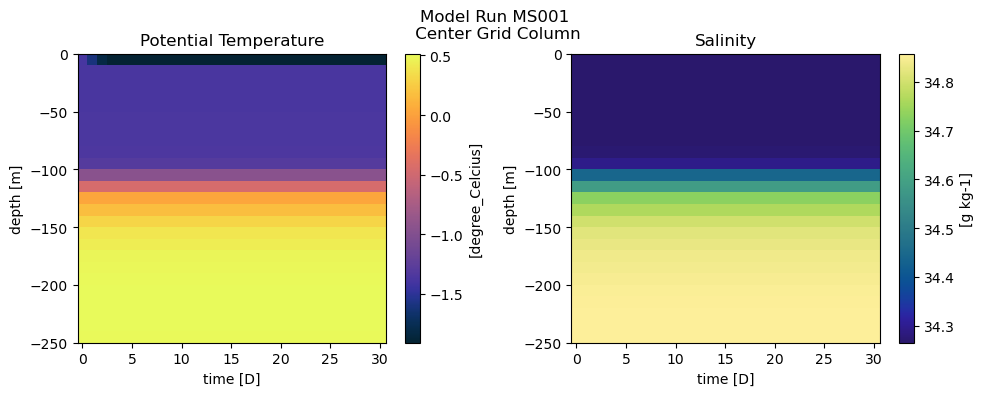

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

single_column_time_evol(ds, "T", ax = axs[0], cmap = cmo.thermal)
single_column_time_evol(ds, "S", ax = axs[1], cmap = cmo.haline)

fig.tight_layout()
fig.suptitle("Model Run " + model_run + "\n Center Grid Column")

## 3D Cube

Plot the whole model domain in a 3D plot with animation to show the temporal evolution (only the faces of the cube are plotted). The animation is opened in a browser window.

Plotly 3D-surface plot examples: https://plotly.com/python/3d-surface-plots/
Plotly Exmaple Animations: https://plotly.com/python/animations/

Documentation: https://plotly.com/python/reference/surface/

In [ ]:
# Improvenemts to make:
# - which side is N/S/E/W?
# - convert x/y to lat/lon if possible
# - add other display/save options
# - resolve issue with cube ending on center points of the outermost cells instead of on their edges
# - implement handling of XG, YG, Zl coordinates, so that velocity components can also be plotted

In [ ]:
def make_face(ds, face, var, cmin, cmax,colorscale="Viridis"):
    """
    Create a Plotly surface for one cube face.

    Parameters
    ----------
    ds : MITgcm output dataset with only one time (i.e. a snapshot)
    face : str
        One of: 'top', 'bottom', 'front', 'back', 'right', 'left'
    var : str
        Name of variable in ds (e.g. "T", "S")
    cmin, cmax : float
        Global color limits for surfacecolor
    colorscale : str, optional
        Plotly colorscale to use for surfacecolor
    """

    x = ds["XC"].values
    y = ds["YC"].values
    z = ds["Z"].values
    V = ds[var]

    if face == "top":
        face_values = V.isel(Z=0)
        x_face, y_face = np.meshgrid(x, y, indexing="xy")
        z_face = np.full_like(x_face, z[0])

    elif face == "bottom":
        face_values = V.isel(Z=-1)
        x_face, y_face = np.meshgrid(x, y, indexing="xy")
        z_face = np.full_like(x_face, z[-1])

    elif face == "front":
        face_values = V.isel(YC=0)
        x_face, z_face = np.meshgrid(x, z, indexing="xy")
        y_face = np.full_like(x_face, y[0])

    elif face == "back":
        face_values = V.isel(YC=-1)
        x_face, z_face = np.meshgrid(x, z, indexing="xy")
        y_face = np.full_like(x_face, y[-1])

    elif face == "right":
        face_values = V.isel(XC=-1)
        y_face, z_face = np.meshgrid(y, z, indexing="xy")
        x_face = np.full_like(y_face, x[-1])

    elif face == "left":
        face_values = V.isel(XC=0)
        y_face, z_face = np.meshgrid(y, z, indexing="xy")
        x_face = np.full_like(y_face, x[0])

    else:
        raise ValueError("Invalid face name")
    
    # grid lines
    x_edges = grid_edges_from_centers(ds["XC"].values)
    y_edges = grid_edges_from_centers(ds["YC"].values)
    z_edges = grid_edges_from_centers(ds["Z"].values)

    return go.Surface(
        x=x_face,
        y=y_face,
        z=z_face,
        surfacecolor=face_values.values,
        colorscale=colorscale,
        cmin=cmin,
        cmax=cmax,
        showscale=(face=="top") # this ensures that only one colorbar is shown
    )

def grid_edges_from_centers(c):
    """
    Helper function to compute cell edges from cell center coordinates for the visualization of the model grid. 
    Only the outermost lines remain on cell centers instead of being shifted to edges
    because the surface also end on the center points.

    Parameters
    ----------
    c : coordinate array of cell centers
    Returns
    -------
    edges : array
        Coordinate array of cell edges
    """
    mid = 0.5 * (c[:-1] + c[1:])
    first = c[0] # this is the center coordintate of the first cell
    last  = c[-1] # this is the center coordinate of the last cell
    edges = np.concatenate([[first], mid, [last]])

    return edges

def add_model_grid_lines(fig, ds, faces=None, line_color="black", line_width=1):
    """
    Add grid lines along cube surfaces representing the model grid.
    """
    if faces is None:
        faces = ["top","bottom","front","back","right","left"]

    # Compute cell edges
    edges = {
        "XC": grid_edges_from_centers(ds["XC"].values),
        "YC": grid_edges_from_centers(ds["YC"].values),
        "Z":  grid_edges_from_centers(ds["Z"].values)
    }

    # Define fixed coordinate and the two varying axes for each face
    face_def = {
        "top":    ("Z", edges["Z"][0], ["XC","YC"]),
        "bottom": ("Z", edges["Z"][-1], ["XC","YC"]),
        "front":  ("YC", edges["YC"][0], ["XC","Z"]),
        "back":   ("YC", edges["YC"][-1], ["XC","Z"]),
        "right":  ("XC", edges["XC"][-1], ["YC","Z"]),
        "left":   ("XC", edges["XC"][0], ["YC","Z"])
    }

    for face in faces:
        fixed_axis, fixed_val, var_axes = face_def[face]
        # Loop over line positions along first varying axis (except first and last as they would be on the cube edges)
        for v in edges[var_axes[1]][1:-1]:
            coords = {fixed_axis: fixed_val,
                      var_axes[0]: edges[var_axes[0]][0],  # start
                      var_axes[1]: v}
            coords_end = coords.copy()
            coords_end[var_axes[0]] = edges[var_axes[0]][-1]  # end

            fig.add_trace(go.Scatter3d(
                x=[coords["XC"], coords_end["XC"]],
                y=[coords["YC"], coords_end["YC"]],
                z=[coords["Z"], coords_end["Z"]],
                mode="lines",
                line=dict(color=line_color, width=line_width),
                showlegend=False
            ))

        # Loop over line positions along second varying axis (except first and last as they would be on the cube edges)
        for v in edges[var_axes[0]][1:-1]:
            coords = {fixed_axis: fixed_val,
                      var_axes[0]: v,
                      var_axes[1]: edges[var_axes[1]][0]}  # start
            coords_end = coords.copy()
            coords_end[var_axes[1]] = edges[var_axes[1]][-1]  # end

            fig.add_trace(go.Scatter3d(
                x=[coords["XC"], coords_end["XC"]],
                y=[coords["YC"], coords_end["YC"]],
                z=[coords["Z"], coords_end["Z"]],
                mode="lines",
                line=dict(color=line_color, width=line_width),
                showlegend=False
            ))

    return fig

def cube_time_evol(ds, var, model_run="", colorscale="Viridis", quarter=False):
    """
    Create a 3D cube plot with time evolution for a given variable using Plotly (animated surface plot).

    Parameters
    ----------
    ds : MITgcm output dataset with time dimension
    var : str
        Name of variable in ds (e.g. "T", "S")
    model_run : str, optional
        Model run name to include in the title
    colorscale : str, optional
        Plotly colorscale to use for surfacecolor
    quarter : bool, optional
        If True, plot quarter of domain so that the crossections are vissible.
    """
    title_suffix = ""

    if quarter:
        Nx = len(ds.XC)
        Ny = len(ds.YC)
        ds = ds.isel(XC=slice(0,int(Nx/2)), YC=slice(0,int(Ny/2)))

        title_suffix = "Quarter Domain"

    # Global color limits -> all faces can have the same color scale
    cmin = np.min(ds[var].values)
    cmax = np.max(ds[var].values)

    faces = ["top", "bottom", "front", "back", "right", "left"]

    # FIRST FRAME
    # For timestep 0, create surfaces for all faces
    face_data = [make_face(ds.isel(time=0), f, var, cmin, cmax, colorscale) for f in faces]
    # make colorbar
    face_data[0].update(showscale=True)
    # set colorbar title
    face_data[0].update(colorbar=dict(title=var + " [" + ds[var].units + "]"))

    # REMAINING FRAMES
    frames = []
    nt = len(ds["time"])
    for t in range(nt):
        dsi = ds.isel(time=t)
        frame_data = [make_face(dsi, f, var, cmin, cmax, colorscale) for f in faces]
        frames.append(go.Frame(data=frame_data, name=str(t)))

    # CREATE FIGURE
    fig = go.Figure(data=face_data, frames=frames)

    fig = add_model_grid_lines(fig, ds.isel(time=0), faces=faces, line_color="darkgrey", line_width=1)
    

    fig.update_layout(
        title="Model Run " + model_run + "<br>Time Evolution of " + var + "<br>" + title_suffix,
        scene=dict(
            xaxis=dict(title="XC"),
            yaxis=dict(title="YC"),
            zaxis=dict(title="Z [m]")
        ),
        width=850, height=750,
        updatemenus=[dict(
            type="buttons",
            buttons=[dict(label="Play", method="animate", args=[None])]
        )],
        sliders=[dict(
            steps=[dict(method="animate", args=[[str(t)]], label=f"{t}")
                for t in range(nt)]
        )]
    )
    fig.show(renderer="browser")


In [111]:
cube_time_evol(ds, "T", model_run, colorscale="thermal")

## 3D Crossection

In [ ]:
cube_time_evol(ds, "T", model_run, colorscale="thermal", quarter=True)